## **Functions and Classes**

### **Packages and Utilities**

#### **Import Some Packages**

In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchmetrics import R2Score

# Data process
import numpy as np
import pandas as pd
import math
import csv
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold


# Plot figure
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#### **Reproducibility**

In [2]:
myseed = 870529  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

#### **Switch to GPU if available**

In [3]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

### **Dataset**

We have two kinds of datasets:
* `train`: for training and validation
* `test`: for testing 

The `TrajDataset` below does:
* read `.xlsx` files
* extract features
* normalize features


In [4]:
class TrajDataset(Dataset):
    def __init__(self, path, mode='test'):

        # Read data to dataframe
        df = pd.read_excel(path)

        # Split data to feature and target & Transfer to numpy 
        feature_np = df.iloc[:, 1:10].to_numpy()
        target_np = df.iloc[:, 10:13].to_numpy()
        
        # Transfer data to tensor
        self.feature = torch.Tensor(feature_np)
        self.target = torch.Tensor(target_np)

        # Transfer feature data to (0,1) -> MinMaxScalar
        self.feature[:, 1:4] = (self.feature[:, 1:4] + 150) / 300
        self.feature[:, 4:7] = (self.feature[:, 4:7] + 830) / 1660      
        self.feature[:, 7:10] = (self.feature[:, 7:10] + 980) / 1960

        # Get sample number of data
        self.dim = self.feature.shape[1]

        print('Finished reading the Trajectory Dataset ({} samples found, each dim = {})'
              .format(len(self.feature), self.dim))

    def __getitem__(self, index) :


        return self.feature[index], self.target[index]

    def __len__(self) :

        return len(self.feature)

### **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 7 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.

In [5]:
class DDNN(nn.Module) : 
    def __init__(self, layers):
        super(DDNN, self).__init__()

        input_dim = 9
        output_dim = 3

        h1, h2, h3 = layers[1], layers[2], layers[3]
        h4, h5  = layers[4], layers[5]

        # Layer Strucutre
        self.l1 = nn.Linear(input_dim, h1)
        self.l2 = nn.Linear(h1, h2)
        self.l3 = nn.Linear(h2, h3)
        self.l4 = nn.Linear(h3, h4)
        self.l5 = nn.Linear(h4, h5)
        self.l6 = nn.Linear(h5, output_dim)


        # Define Activation Function 
        # Use Softplus for smoother result (compared with ReLU)
        self.act1 = nn.Softplus()
        self.act2 = nn.Softplus()
        self.act3 = nn.Softplus()
        self.act4 = nn.Softplus()
        self.act5 = nn.Softplus()


    def forward(self, x):
        
        x = self.l1(x)
        x = self.act1(x)
        x = self.l2(x)
        x = self.act2(x)
        x = self.l3(x)
        x = self.act3(x)
        x = self.l4(x)
        x = self.act4(x)
        x = self.l5(x)
        x = self.act5(x)
        x = self.l6(x)

        return x
    


#### **Get hidden layer value**

In [6]:
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

#### **Inverse Dynamics**

In [7]:
def InvDyn(tk_space):

    samples = tk_space.shape[0]    
    # Parameters
    unit = 1000
    L_init = (518.067753315)/unit
    D = (450 - 160)/unit
    Norm_Z = 429.295/unit

    # Task space data
    x_raw, y_raw, z_raw = tk_space[:, 0], tk_space[:, 1], tk_space[: , 2]
    x_d_raw, y_d_raw, z_d_raw = tk_space[:, 3], tk_space[:, 4], tk_space[: , 5]
    x_dd_raw, y_dd_raw, z_dd_raw = tk_space[:, 6], tk_space[:, 7], tk_space[:, 8]


    x, y, z = (300*x_raw-150)/unit, (300*y_raw-150)/unit, (300*z_raw-150)/unit
    x_d, y_d, z_d = (1660*x_d_raw-830)/unit, (1660*y_d_raw-830)/unit, (1660*z_d_raw-830)/unit
    x_dd, y_dd, z_dd = (1960 * x_dd_raw - 980)/unit, (1960 * y_dd_raw - 980)/unit, (1960 * z_dd_raw - 980)/unit


    L1 = torch.sqrt( x**2 + (y-D)**2 + (z-Norm_Z)**2 ) 
    L2 = torch.sqrt( (x + math.sqrt(3) * D / 2) **2 + ( y+D/2 )**2 + (z-Norm_Z)**2 ) 
    L3 = torch.sqrt( (x - math.sqrt(3) * D / 2) **2 + ( y+D/2 )**2 + (z-Norm_Z)**2 ) 
    
    L1_d = x / L1 * x_d + ( y - D ) / L1 * y_d + ( z - Norm_Z ) / L1 * z_d  
    L2_d = (x + math.sqrt(3) * D / 2 ) / L2 * x_d + ( y + D / 2 ) / L2 * y_d + ( z - Norm_Z ) / L2 * z_d
    L3_d = (x - math.sqrt(3) * D / 2 ) / L3 * x_d + ( y + D / 2 ) / L3 * y_d + ( z - Norm_Z ) / L3 * z_d 

    L1_dd =  x / L1 * (x_dd - x_d * L1_d/L1) + x_d**2 / L1 + \
        ( y - D ) * (y_dd - y_d * L1_d / L1) + y_d**2 / L1 + \
        ( z - Norm_Z ) * (z_dd - z_d * L1_d / L1) + z_d**2 / L1 
    L2_dd = (x + math.sqrt(3) * D / 2 ) / L2 * (x_dd - x_d * L2_d / L2) + x_d**2 / L2 + \
        (y + D / 2) / L2 * (y_dd - y_d * L2_d / L2) + y_d**2 / L2 + \
        ( z - Norm_Z ) / L2 * (z_dd - z_d * L2_d / L2) + z_d**2 / L2
    L3_dd = (x - math.sqrt(3) * D / 2 ) / L3 * (x_dd - x_d * L3_d / L3) + x_d**2 / L3 + \
        (y + D / 2) / L3 * (y_dd - y_d * L3_d / L3) + y_d**2 / L3 + \
        ( z - Norm_Z ) / L3 * (z_dd - z_d * L3_d / L3) + z_d**2 / L3

    L1, L2, L3 =  torch.reshape(L1, (samples, -1)), torch.reshape(L2, (samples, -1)), torch.reshape(L3, (samples, -1))  
    L1_d, L2_d, L3_d =  torch.reshape(L1_d, (samples, -1)), torch.reshape(L2_d, (samples, -1)), torch.reshape(L3_d, (samples, -1))
    L1_dd, L2_dd, L3_dd =  torch.reshape(L1_dd, (samples, -1)), torch.reshape(L2_dd, (samples, -1)), torch.reshape(L3_dd, (samples, -1)) 
            
    jt_space = torch.cat((L1, L2, L3, L1_d, L2_d, L3_d, L1_dd, L2_dd, L3_dd),1)
    
    return jt_space

#### **Custom Loss**

In [8]:
class CustomLoss(nn.Module):
    def __init__(self, mode='mse'):
        super(CustomLoss, self).__init__()
        self.mode = mode

    def forward(self, output, target, tk_space, jt_space):

        if self.mode == 'phys1':

            jt_target = InvDyn(tk_space) 

            mse_loss = torch.mean((output-target)**2)

            pen_loss = torch.mean((jt_space-jt_target)**2)

            penalty = 10**(2)

            total_loss = mse_loss + penalty * pen_loss

            return total_loss, mse_loss, penalty * pen_loss

        elif self.mode == 'phys2':

            # Parameters
            L_init = 518.067753315/1000
            D = (450 - 160)/1000
            Norm_Z = 429.295/1000
            # Task space data
            x_raw, y_raw, z_raw = tk_space[:, 0], tk_space[:, 1], tk_space[: , 2]
            x_d_raw, y_d_raw, z_d_raw = tk_space[:, 3], tk_space[:, 4], tk_space[: , 5]
            x_dd_raw, y_dd_raw, z_dd_raw = tk_space[:, 6], tk_space[:, 7], tk_space[:, 8]

            L1_pred, L2_pred, L3_pred = jt_space[:, 0], jt_space[:, 1], jt_space[: , 2]
            L1_d_pred, L2_d_pred, L3_d_pred = jt_space[:, 3], jt_space[:, 4], jt_space[: , 5]
            L1_dd_pred, L2_dd_pred, L3_dd_pred = jt_space[:, 6], jt_space[:, 7], jt_space[:, 8]

            x, y, z = (300*x_raw-150)/100, (300*y_raw-150)/100, (300*z_raw-150)/100
            x_d, y_d, z_d = (1660*x_d_raw-830)/100, (1660*y_d_raw-830)/100, (1660*z_d_raw-830)/100
            x_dd, y_dd, z_dd = (1960 * x_dd_raw - 980)/100, (1960 * y_dd_raw - 980)/100, (1960 * z_dd_raw - 980)/100

            L1_target = torch.sqrt( x**2 + (y-D)**2 + (z-Norm_Z)**2 ) 
            L2_target = torch.sqrt( (x + math.sqrt(3) * D / 2) **2 + ( y+D/2 )**2 + (z-Norm_Z)**2 ) 
            L3_target = torch.sqrt( (x - math.sqrt(3) * D / 2) **2 + ( y+D/2 )**2 + (z-Norm_Z)**2 ) 
            
            L1_d_target = x / L1_target * x_d + ( y - D ) / L1_target * y_d + ( z - Norm_Z ) / L1_target * z_d  
            L2_d_target = (x + math.sqrt(3) * D / 2 ) / L2_target * x_d + ( y + D / 2 ) / L2_target * y_d + ( z - Norm_Z ) / L2_target * z_d
            L3_d_target = (x - math.sqrt(3) * D / 2 ) / L3_target * x_d + ( y + D / 2 ) / L3_target * y_d + ( z - Norm_Z ) / L3_target * z_d 

            L1_dd_target =  x / L1_target * (x_dd - x_d * L1_d_target/L1_target) + x_d**2 / L1_target + \
                ( y - D ) * (y_dd - y_d * L1_d_target / L1_target) + y_d**2 / L1_target + \
                ( z - Norm_Z ) * (z_dd - z_d * L1_d_target / L1_target) + z_d**2 / L1_target
            L2_dd_target = (x + math.sqrt(3) * D / 2 ) / L2_target * (x_dd - x_d * L2_d_target / L2_target) + x_d**2 / L2_target + \
                (y + D / 2) / L2_target * (y_dd - y_d * L2_d_target / L2_target) + y_d**2 / L2_target + \
                ( z - Norm_Z ) / L2_target * (z_dd - z_d * L2_d_target / L2_target) + z_d**2 / L2_target
            L3_dd_target = (x - math.sqrt(3) * D / 2 ) / L3_target * (x_dd - x_d * L3_d_target / L3_target) + x_d**2 / L3_target + \
                (y + D / 2) / L3_target * (y_dd - y_d * L3_d_target / L3_target) + y_d**2 / L3_target + \
                ( z - Norm_Z ) / L3_target * (z_dd - z_d * L3_d_target / L3_target) + z_d**2 / L3_target


            pos_target, pos_pred = torch.stack((L1_target, L2_target, L3_target), -1), torch.stack((L1_pred, L2_pred, L3_pred), -1)
            vel_target, vel_pred = torch.stack((L1_d_target, L2_d_target, L3_d_target), -1), torch.stack((L1_d_pred, L2_d_pred, L3_d_pred), -1) 
            acc_target, acc_pred = torch.stack((L1_dd_target, L2_dd_target, L3_dd_target), -1), torch.stack((L1_dd_pred, L2_dd_pred, L3_dd_pred), -1) 

            mse_loss = torch.mean((output-target)**2)
            pos_loss = torch.mean((pos_pred-pos_target)**2)
            vel_loss = torch.mean((vel_pred-vel_target)**2)
            acc_loss = torch.mean((acc_pred-acc_target)**2)

            pos_pen = 1
            vel_pen = 1
            acc_pen = 1

            pen_loss = pos_loss + vel_loss + acc_loss

            total_loss = mse_loss + pos_pen * pos_loss + vel_pen * vel_loss + acc_pen * acc_loss

            return total_loss, mse_loss, pen_loss
        
        else :

            jt_target = InvDyn(tk_space) 

            mse_loss = torch.mean((output-target)**2)

            pen_loss = torch.mean((jt_space-jt_target)**2)

            penalty = 0

            total_loss = mse_loss + penalty * pen_loss

            return total_loss, mse_loss, pen_loss

       

### **Train/Dev/Test**

We have three kinds of dataloaders:
* `train`: for training
* `valid`: for validation
* `test`: for testing 

#### **Hyper-parameters Setup**

`config` contains hyper-parameters for training and the path to save your model.

In [9]:
device = get_device()
os.makedirs('models', exist_ok=True) 

config = {
    'n_epochs': 50,                    # maximum number of epochs
    'batch_size': 16,                   # mini-batch size for dataloader
    'optimizer': 'Adam',                # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                   # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.0005433177089293607                     # learning rate of Adam
    },
    'layers': np.array([9, 189, 119, 9, 53, 85, 3], dtype='int64'),    # layers of NN architecture
    'early_stop': 200,                  # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pt'      # your model will be saved here
}

### **Read Records**

In [10]:
import pickle

record_path = 'records/record_DDNN.pkl'
f = open(record_path, 'rb')
DDNN_noisefree = pickle.load(f)

record_path = 'records/record_PGNN.pkl'
f = open(record_path, 'rb')
PGNN_noisefree = pickle.load(f)

record_path = 'records/record_ReLU_DDNN.pkl'
f = open(record_path, 'rb')
ReLU_DDNN_noisefree = pickle.load(f)

record_path = 'records/record_ReLU_PGNN.pkl'
f = open(record_path, 'rb')
ReLU_PGNN_noisefree = pickle.load(f)

record_path = 'records/record_DDNN_noised.pkl'
f = open(record_path, 'rb')
DDNN_noise = pickle.load(f)

record_path = 'records/record_PGNN_noised.pkl'
f = open(record_path, 'rb')
PGNN_noise = pickle.load(f)

record_path = 'records/record_DDNN_half.pkl'
f = open(record_path, 'rb')
DDNN_half = pickle.load(f)

record_path = 'records/record_PGNN_half.pkl'
f = open(record_path, 'rb')
PGNN_half = pickle.load(f)

record_path = 'records/record_PGNN_0_1e-3_1.pkl'
f = open(record_path, 'rb')
PGNN_0_1e_3 = pickle.load(f)

record_path = 'records/record_PGNN_1_1e-3_1.pkl'
f = open(record_path, 'rb')
PGNN_1_1e_3 = pickle.load(f)

record_path = 'records/record_PGNN_10_1e-3_1.pkl'
f = open(record_path, 'rb')
PGNN_10_1e_3 = pickle.load(f)

record_path = 'records/record_PGNN_100_1e-3_1.pkl'
f = open(record_path, 'rb')
PGNN_100_1e_3 = pickle.load(f)

record_path = 'records/record_PGNN_1000_1e-3_1.pkl'
f = open(record_path, 'rb')
PGNN_1000_1e_3 = pickle.load(f)

record_path = 'records/record_PGNN_10000_1e-3_1.pkl'
f = open(record_path, 'rb')
PGNN_10000_1e_3 = pickle.load(f)


### **Plot Learning Curve**

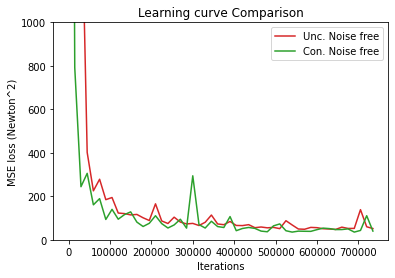

In [12]:
total_steps = len(PGNN_noisefree['fold1']['tr_mse'])
x_1 = range(total_steps)
x_2 = x_1[::len(PGNN_noisefree['fold1']['tr_mse']) // len(PGNN_noisefree['fold1']['vd_mse'])]

up_limit=1000.

figure(figsize=(6, 4))



plt.plot(x_2, DDNN_noisefree['fold1']['vd_mse'], c='tab:red', label='Unc. Noise free')
plt.plot(x_2, PGNN_noisefree['fold1']['vd_mse'], c='tab:green', label='Con. Noise free')

# plt.plot(x_2, DDNN_noise['fold1']['vd_mse'], c='tab:blue', label='Unc. noise')
# plt.plot(x_2, PGNN_noise['fold1']['vd_mse'], c='tab:cyan', label='Con. noise')


plt.ylim(0.0, up_limit)
plt.xlabel('Iterations')
plt.ylabel('MSE loss (Newton^2)')
plt.title('Learning curve Comparison')
plt.legend()
plt.show()


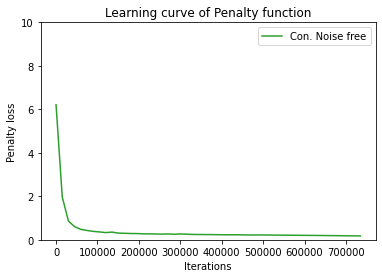

In [13]:
up_limit=10.
figure(figsize=(6, 4))


plt.plot(x_2, PGNN_noisefree['fold1']['vd_pen'], c='tab:green', label='Con. Noise free')

plt.ylim(0.0, up_limit)
plt.xlabel('Iterations')
plt.ylabel('Penalty loss')
plt.title('Learning curve of Penalty function')
plt.legend()
plt.show()


### **Testing**

In [ ]:
def test(ts_dataset, model, criterion, device, lim=35., preds=None, targets=None):
    ts_loader = DataLoader(ts_dataset, config['batch_size'], shuffle = False, 
    drop_last=False, num_workers=0, pin_memory=True)
    sample_num = len(ts_dataset)
    hookF = [Hook(layer[1]) for layer in list(model._modules.items())]

    if preds is None or targets is None:
        model.eval()
        preds, targets, jtlayers = [], [], []
        total_loss = 0
        total_ts_mse = 0
        total_ts_pen = 0
        cnt = 0
        for x, y in ts_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())

                jtlayer = hookF[2].output
                jtlayers.append(jtlayer.detach().cpu())
                ts_loss, ts_mse, ts_pen = criterion(pred, y, x, jtlayer)

            cnt = cnt+1
            total_loss = total_loss +  ts_mse.detach().cpu().item() * len(x) + ts_pen    # ( *len(x) means error**2)            
            total_ts_mse = total_ts_mse + ts_mse.detach().cpu().item() * len(x)
            total_ts_pen = total_ts_pen + ts_pen

        total_loss = total_loss / len(ts_loader.dataset)            # Calculate validation loss with each epoch (Criterion within CLASS model)
        total_ts_mse = total_ts_mse / len(ts_loader.dataset)
        total_ts_pen = total_ts_pen / len(ts_loader.dataset)
        preds = torch.cat(preds, 0).numpy().reshape((sample_num, 3))
        targets = torch.cat(targets, 0).numpy().reshape((sample_num, 3))
        jtlayers = torch.cat(jtlayers, 0).numpy().reshape((sample_num, 9))
    return total_loss, total_ts_mse, total_ts_pen, preds, targets, jtlayers

### **Testing with trained NN**

Finished reading the Trajectory Dataset (10000 samples found, each dim = 9)


C:\Users\Wilson Chen\AppData\Local\Temp\ipykernel_18228\4245920301.py:60: DeprecationWarning: Call to deprecated function remove_sheet (Use wb.remove(worksheet) or del wb[sheetname]).
  wb.remove_sheet(wb.active)


0.9992027833018557 0.999794452318768 0.999811041425236
total_loss : 29.728252, mse : 29.712104, pen : 0.016155
0.9966855903085988 0.999399599712413 0.9991714756419465


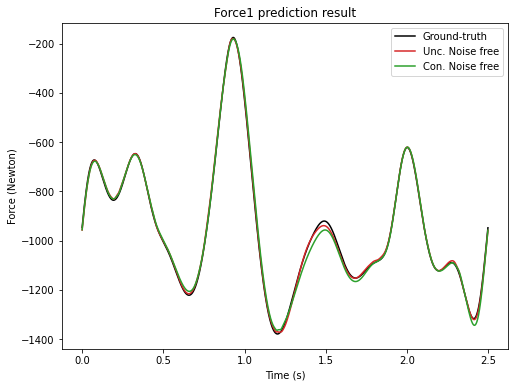

total_loss : 118.760689, mse : 118.739850, pen : 0.020940


In [13]:
ts_path = os.path.abspath("./Resources/TestingData_PeriodicTraj_Single.xlsx")
ts_dataset = TrajDataset(ts_path)

test_config = {'save_path' : 'models/model_DDNN.pt'}

model = DDNN(config['layers']).to(device)
ckpt = torch.load(test_config['save_path'], map_location='cpu')  # Load trained model
model.load_state_dict(ckpt)

criterion = CustomLoss(mode='mse')


from sklearn.metrics import r2_score


ts_loss, ts_mse, ts_pen, pred, target, jtlayers = test(ts_dataset, model, criterion, device)

ts_accuracy_1 = r2_score(pred[:, 0], target[:, 0])
ts_accuracy_2 = r2_score(pred[:, 1], target[:, 1])
ts_accuracy_3 = r2_score(pred[:, 2], target[:, 2])

print(ts_accuracy_1, ts_accuracy_2, ts_accuracy_3)


index=0

figure(figsize=(8, 6))
total_steps = len(pred)
x_1 = np.linspace(0,2.499,total_steps)

plt.plot(x_1, target[:, index], c='black', label='Ground-truth')
plt.plot(x_1, pred[:, index], c='tab:red', label='Unc. Noise free')

act_pos=jtlayers[:, 0:3]
act_vel=jtlayers[:, 3:6]
act_accel=jtlayers[:, 6:9]


print('total_loss : {:4f}, mse : {:4f}, pen : {:4f}'.format(ts_loss.item(), ts_mse, ts_pen.item()))


test_config = {'save_path' : 'models/model_PGNN.pt'}


model = DDNN(config['layers']).to(device)
ckpt = torch.load(test_config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
criterion = CustomLoss(mode='mse')


def test(ts_dataset, model, criterion, device, lim=35., preds=None, targets=None):
    ts_loader = DataLoader(ts_dataset, config['batch_size'], shuffle = False, 
    drop_last=False, num_workers=0, pin_memory=True)
    sample_num = len(ts_dataset)
    hookF = [Hook(layer[1]) for layer in list(model._modules.items())]

    if preds is None or targets is None:
        model.eval()
        preds, targets, jtlayers = [], [], []
        total_loss = 0
        total_ts_mse = 0
        total_ts_pen = 0
        cnt = 0
        for x, y in ts_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())

                jtlayer = hookF[2].output
                jtlayers.append(jtlayer.detach().cpu())
                ts_loss, ts_mse, ts_pen = criterion(pred, y, x, jtlayer)

            cnt = cnt+1
            total_loss = total_loss +  ts_mse.detach().cpu().item() * len(x) + ts_pen    # ( *len(x) means error**2)            
            total_ts_mse = total_ts_mse + ts_mse.detach().cpu().item() * len(x)
            total_ts_pen = total_ts_pen + ts_pen

        total_loss = total_loss / len(ts_loader.dataset)            # Calculate validation loss with each epoch (Criterion within CLASS model)
        total_ts_mse = total_ts_mse / len(ts_loader.dataset)
        total_ts_pen = total_ts_pen / len(ts_loader.dataset)
        preds = torch.cat(preds, 0).numpy().reshape((sample_num, 3))
        targets = torch.cat(targets, 0).numpy().reshape((sample_num, 3))
        jtlayers = torch.cat(jtlayers, 0).numpy().reshape((sample_num, 9))
    return total_loss, total_ts_mse, total_ts_pen, preds, targets, jtlayers


from sklearn.metrics import r2_score


ts_loss, ts_mse, ts_pen, pred, target, jtlayers = test(ts_dataset, model, criterion, device)


ts_accuracy_1 = r2_score(pred[:, 0], target[:, 0])
ts_accuracy_2 = r2_score(pred[:, 1], target[:, 1])
ts_accuracy_3 = r2_score(pred[:, 2], target[:, 2])

print(ts_accuracy_1, ts_accuracy_2, ts_accuracy_3)

print('total_loss : {:4f}, mse : {:4f}, pen : {:4f}'.format(ts_loss.item(), ts_mse, ts_pen.item()))

plt.plot(x_1, pred[:, index], c='tab:green', label='Con. Noise free')
plt.xlabel('Time (s)')
plt.ylabel('Force (Newton)')
plt.title('Force{} prediction result'.format(index+1))
plt.legend()
plt.savefig("High resoltion.png",dpi=300)
plt.show()


### **Write to Excel**

Finished reading the Trajectory Dataset (10000 samples found, each dim = 9)


C:\Users\Wilson Chen\AppData\Local\Temp\ipykernel_36272\2336131126.py:60: DeprecationWarning: Call to deprecated function remove_sheet (Use wb.remove(worksheet) or del wb[sheetname]).
  wb.remove_sheet(wb.active)


0.9969158279814434 0.99682119039475 0.9967562912384207
total_loss : 256.697388, mse : 250.655481, pen : 6.041882
0.9969158279814434 0.99682119039475 0.9967562912384207


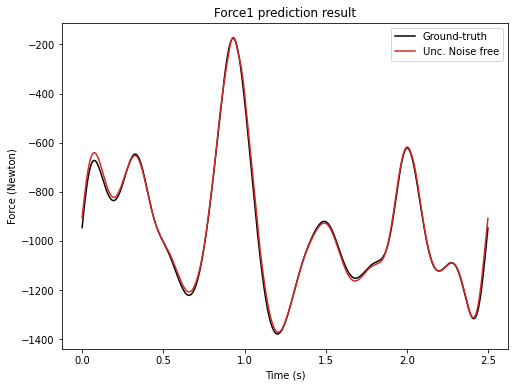

In [ ]:
# import openpyxl
# from openpyxl import load_workbook

# wb = openpyxl.Workbook()
# wb.remove_sheet(wb.active)
# wb.create_sheet('DDNN') 
# sheet = wb['DDNN']

# sheet['A1'].value = 'Force_1'
# sheet['B1'].value = 'Force_2'
# sheet['C1'].value = 'Force_3'

# for i in range(len(pred)):
#     sheet['A' + str(i+2)].value = pred[i,0]
#     sheet['B' + str(i+2)].value = pred[i,1]
#     sheet['C' + str(i+2)].value = pred[i,2]

# wb.save('Prediction.xlsx')

### **Convert jupyter notebook file to python file**
Uncomment the script below to convert jupyter notebook file (.ipynb) to python file (.py)

In [ ]:
# !jupyter nbconvert --to script DataAnalysis_0804.ipynb